# Power Analysis for Fossil AI Feedback System — Image Quality Outcomes

This notebook calculates the required sample size to detect meaningful improvements in image quality across different feedback mechanisms (baseline, post-capture feedback, real-time feedback).

## Research Question
Do different feedback mechanisms (no feedback vs. post-capture feedback vs. real-time feedback) improve the quality of fossil photographs submitted by citizen scientists?

**Note**: This analysis focuses on image quality outcomes. Usability evaluation requires separate analysis.

In [2]:
%pip install -q statsmodels scipy seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.power import tt_ind_solve_power, zt_ind_solve_power
from statsmodels.stats.proportion import proportion_effectsize
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


## 1. Define Baseline Metrics from Current Data

Based on expert-graded fossil images, the baseline quality distribution shows most submissions are grade 3-4 (moderate to good quality). The study compares three conditions:
- **Control (baseline)**: No feedback provided
- **Post-capture feedback**: AI feedback shown after capture with option to retake
- **Real-time feedback**: Live AI feedback displayed in camera viewfinder

The goal is to determine which feedback mechanism produces the greatest improvement in image quality.

Baseline (no feedback) mean quality score: 3.15
Post-capture feedback mean quality score: 3.46
Real-time feedback mean quality score: 3.66

Expected improvement (post-capture vs baseline): 0.31 points
Expected improvement (real-time vs baseline): 0.51 points
Expected improvement (real-time vs post-capture): 0.20 points


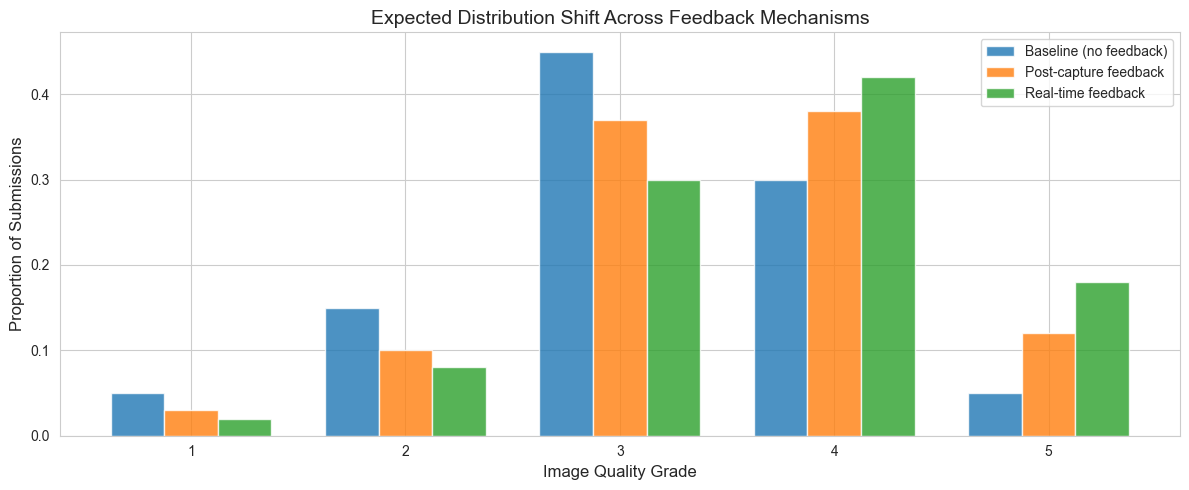

In [3]:
# Baseline quality distribution (from expert grading of 100 images)
# Grades: 1 (very poor) to 5 (excellent)
# Control group: No feedback (baseline UI)
baseline_distribution = {
    1: 0.05,  # 5% very poor
    2: 0.15,  # 15% poor
    3: 0.45,  # 45% moderate
    4: 0.30,  # 30% good
    5: 0.05   # 5% excellent
}

# Expected distribution WITH post-capture feedback (hypothesis)
# Users receive feedback after taking photo, can retake
post_capture_distribution = {
    1: 0.03,  # 3% very poor
    2: 0.10,  # 10% poor
    3: 0.37,  # 37% moderate
    4: 0.38,  # 38% good
    5: 0.12   # 12% excellent
}

# Expected distribution WITH real-time feedback (hypothesis)
# Users receive live feedback in camera viewfinder
realtime_distribution = {
    1: 0.02,  # 2% very poor
    2: 0.08,  # 8% poor
    3: 0.30,  # 30% moderate
    4: 0.42,  # 42% good
    5: 0.18   # 18% excellent
}

# Calculate mean quality scores
baseline_mean = sum(grade * prop for grade, prop in baseline_distribution.items())
post_capture_mean = sum(grade * prop for grade, prop in post_capture_distribution.items())
realtime_mean = sum(grade * prop for grade, prop in realtime_distribution.items())

print(f"Baseline (no feedback) mean quality score: {baseline_mean:.2f}")
print(f"Post-capture feedback mean quality score: {post_capture_mean:.2f}")
print(f"Real-time feedback mean quality score: {realtime_mean:.2f}")
print()
print(f"Expected improvement (post-capture vs baseline): {post_capture_mean - baseline_mean:.2f} points")
print(f"Expected improvement (real-time vs baseline): {realtime_mean - baseline_mean:.2f} points")
print(f"Expected improvement (real-time vs post-capture): {realtime_mean - post_capture_mean:.2f} points")

# Visualize distributions
fig, ax = plt.subplots(figsize=(12, 5))
x = list(baseline_distribution.keys())
baseline_vals = [baseline_distribution[k] for k in x]
post_vals = [post_capture_distribution[k] for k in x]
realtime_vals = [realtime_distribution[k] for k in x]

width = 0.25
x_pos = np.arange(len(x))
ax.bar(x_pos - width, baseline_vals, width, label='Baseline (no feedback)', alpha=0.8)
ax.bar(x_pos, post_vals, width, label='Post-capture feedback', alpha=0.8)
ax.bar(x_pos + width, realtime_vals, width, label='Real-time feedback', alpha=0.8)
ax.set_xlabel('Image Quality Grade', fontsize=12)
ax.set_ylabel('Proportion of Submissions', fontsize=12)
ax.set_title('Expected Distribution Shift Across Feedback Mechanisms', fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(x)
ax.legend()
plt.tight_layout()
plt.show()

## 2. Calculate Effect Sizes

Effect size quantifies the magnitude of difference between groups. Cohen's d is calculated for three pairwise comparisons:
1. Post-capture feedback vs Baseline (no feedback)
2. Real-time feedback vs Baseline (no feedback)
3. Real-time feedback vs Post-capture feedback

The smallest effect size will determine the required sample size (most conservative estimate).

In [4]:
# Estimate standard deviation from ordinal scale (1-5)
# Assume SD approximately 0.9-1.0 for 5-point scale with moderate spread
baseline_std = 0.95
post_capture_std = 0.92  # Slightly lower variance with feedback
realtime_std = 0.88      # Lowest variance (most consistent quality)

# Effect sizes for pairwise comparisons
# 1. Post-capture vs Baseline
pooled_std_post = np.sqrt((baseline_std**2 + post_capture_std**2) / 2)
cohens_d_post = (post_capture_mean - baseline_mean) / pooled_std_post

# 2. Real-time vs Baseline
pooled_std_realtime = np.sqrt((baseline_std**2 + realtime_std**2) / 2)
cohens_d_realtime = (realtime_mean - baseline_mean) / pooled_std_realtime

# 3. Real-time vs Post-capture
pooled_std_comp = np.sqrt((post_capture_std**2 + realtime_std**2) / 2)
cohens_d_comp = (realtime_mean - post_capture_mean) / pooled_std_comp

print("Effect Sizes (Cohen's d):")
print("="*60)
print(f"Post-capture vs Baseline:        {cohens_d_post:.3f}")
print(f"Real-time vs Baseline:            {cohens_d_realtime:.3f}")
print(f"Real-time vs Post-capture:        {cohens_d_comp:.3f}")
print()
print("Effect size interpretation (Cohen's guidelines):")
print("  Small: 0.2   |   Medium: 0.5   |   Large: 0.8")
print("="*60)

def interpret_effect(d):
    if d < 0.3:
        return "SMALL"
    elif d < 0.6:
        return "MEDIUM"
    else:
        return "LARGE"

print(f"\nPost-capture vs Baseline: {interpret_effect(cohens_d_post)} effect")
print(f"Real-time vs Baseline: {interpret_effect(cohens_d_realtime)} effect")
print(f"Real-time vs Post-capture: {interpret_effect(cohens_d_comp)} effect")

Effect Sizes (Cohen's d):
Post-capture vs Baseline:        0.332
Real-time vs Baseline:            0.557
Real-time vs Post-capture:        0.222

Effect size interpretation (Cohen's guidelines):
  Small: 0.2   |   Medium: 0.5   |   Large: 0.8

Post-capture vs Baseline: MEDIUM effect
Real-time vs Baseline: MEDIUM effect
Real-time vs Post-capture: SMALL effect


## 3. Power Analysis — Sample Size Calculation

Calculate required sample size per group to detect the expected effects with:
- Power (1 - β) = 0.80 (80% chance of detecting true effect)
- Significance level (α) = 0.05, Bonferroni-corrected for 3 pairwise comparisons (α = 0.0167)
- Two-tailed tests
- Equal group sizes (balanced design)

The smallest effect (real-time vs post-capture) determines the required sample size.

In [5]:
# Power analysis for independent samples t-test
# Use smallest effect size for conservative estimate (real-time vs post-capture)
alpha = 0.05  # significance level
power = 0.80  # desired statistical power

# For multiple comparisons (3 pairwise tests), apply Bonferroni correction
alpha_corrected = alpha / 3
print(f"Significance level (α): {alpha}")
print(f"Bonferroni-corrected α: {alpha_corrected:.4f}")
print(f"Target power: {power}")
print()

# Calculate required sample size per group for each comparison
comparisons = {
    'Post-capture vs Baseline': cohens_d_post,
    'Real-time vs Baseline': cohens_d_realtime,
    'Real-time vs Post-capture': cohens_d_comp
}

sample_sizes = {}
for name, effect in comparisons.items():
    n = tt_ind_solve_power(
        effect_size=effect,
        alpha=alpha_corrected,
        power=power,
        ratio=1.0,
        alternative='two-sided'
    )
    sample_sizes[name] = n
    print(f"{name:30s}: {np.ceil(n):.0f} per group")

# Maximum sample size needed (most conservative)
max_n_per_group = max(sample_sizes.values())
print()
print("="*70)
print(f"Required sample size per group (most conservative): {np.ceil(max_n_per_group):.0f}")
print(f"Total participants needed (3 groups): {np.ceil(max_n_per_group * 3):.0f}")
print("="*70)
print()
print("Study design:")
print(f"  - Control group (baseline, no feedback): {np.ceil(max_n_per_group):.0f} participants")
print(f"  - Treatment 1 (post-capture feedback):  {np.ceil(max_n_per_group):.0f} participants")
print(f"  - Treatment 2 (real-time feedback):     {np.ceil(max_n_per_group):.0f} participants")
print(f"  - Total sample size:                     {np.ceil(max_n_per_group * 3):.0f} participants")

Significance level (α): 0.05
Bonferroni-corrected α: 0.0167
Target power: 0.8

Post-capture vs Baseline      : 192 per group
Real-time vs Baseline         : 69 per group
Real-time vs Post-capture     : 426 per group

Required sample size per group (most conservative): 426
Total participants needed (3 groups): 1277

Study design:
  - Control group (baseline, no feedback): 426 participants
  - Treatment 1 (post-capture feedback):  426 participants
  - Treatment 2 (real-time feedback):     426 participants
  - Total sample size:                     1277 participants


## 4. Sensitivity Analysis — Effect Size vs Sample Size

Explore how sample size requirements change with different effect sizes.

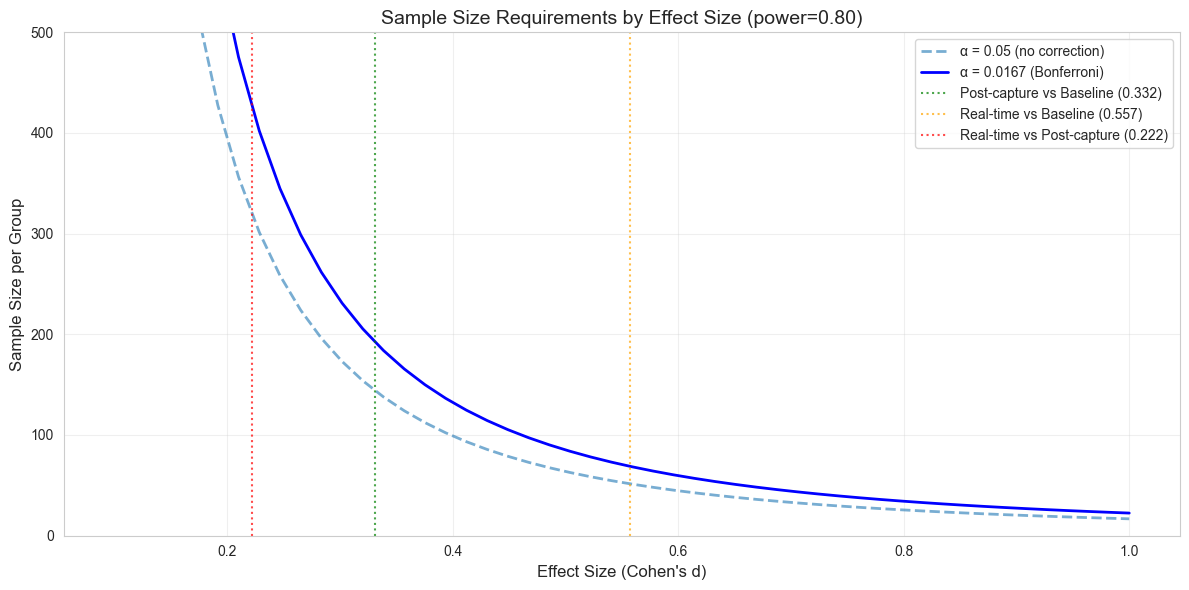

In [6]:
# Range of effect sizes to test
effect_sizes = np.linspace(0.1, 1.0, 50)
sample_sizes_uncorrected = []
sample_sizes_corrected = []

for es in effect_sizes:
    # Without Bonferroni correction
    n_unc = tt_ind_solve_power(
        effect_size=es,
        alpha=0.05,
        power=0.80,
        ratio=1.0,
        alternative='two-sided'
    )
    sample_sizes_uncorrected.append(n_unc)
    
    # With Bonferroni correction
    n_corr = tt_ind_solve_power(
        effect_size=es,
        alpha=0.05/3,
        power=0.80,
        ratio=1.0,
        alternative='two-sided'
    )
    sample_sizes_corrected.append(n_corr)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(effect_sizes, sample_sizes_uncorrected, linewidth=2, label='α = 0.05 (no correction)', linestyle='--', alpha=0.6)
ax.plot(effect_sizes, sample_sizes_corrected, linewidth=2, label='α = 0.0167 (Bonferroni)', color='blue')

# Mark the three comparisons
ax.axvline(cohens_d_post, color='green', linestyle=':', alpha=0.7, label=f"Post-capture vs Baseline ({cohens_d_post:.3f})")
ax.axvline(cohens_d_realtime, color='orange', linestyle=':', alpha=0.7, label=f"Real-time vs Baseline ({cohens_d_realtime:.3f})")
ax.axvline(cohens_d_comp, color='red', linestyle=':', alpha=0.7, label=f"Real-time vs Post-capture ({cohens_d_comp:.3f})")

ax.set_xlabel('Effect Size (Cohen\'s d)', fontsize=12)
ax.set_ylabel('Sample Size per Group', fontsize=12)
ax.set_title('Sample Size Requirements by Effect Size (power=0.80)', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 500])
plt.tight_layout()
plt.show()

## 5. Power Curves — Power vs Sample Size

Visualize statistical power achieved at different sample sizes for the expected effect.

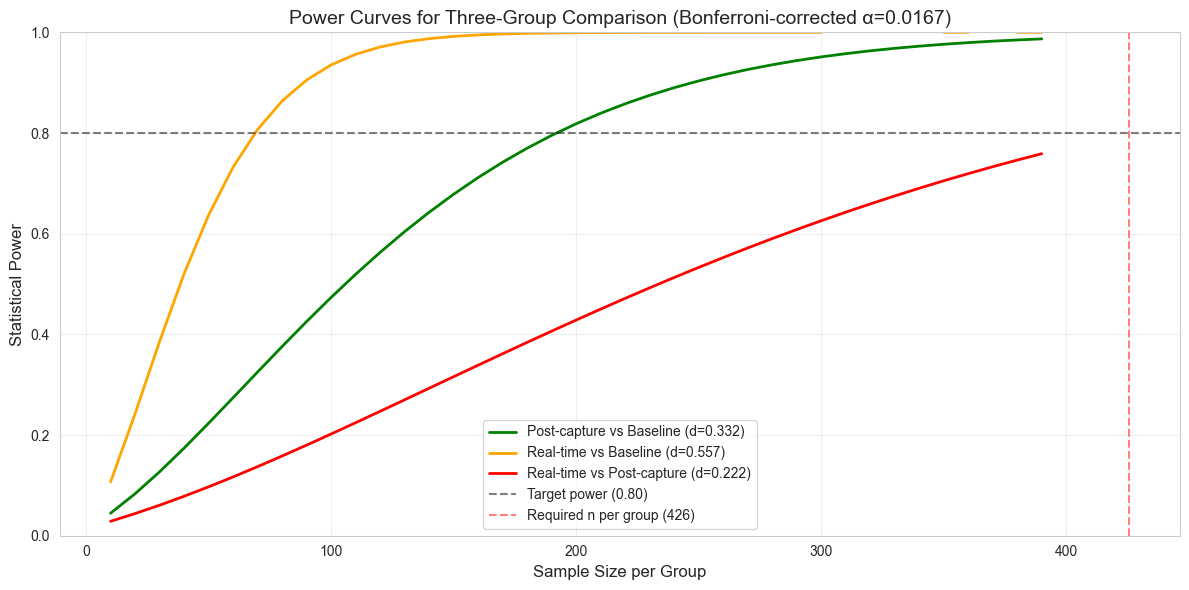

In [7]:
# Range of sample sizes per group
n_range = np.arange(10, 400, 10)

# Calculate power curves for all three comparisons
power_post = []
power_realtime = []
power_comp = []

for n in n_range:
    p1 = tt_ind_solve_power(effect_size=cohens_d_post, nobs1=n, alpha=alpha_corrected, ratio=1.0, alternative='two-sided')
    p2 = tt_ind_solve_power(effect_size=cohens_d_realtime, nobs1=n, alpha=alpha_corrected, ratio=1.0, alternative='two-sided')
    p3 = tt_ind_solve_power(effect_size=cohens_d_comp, nobs1=n, alpha=alpha_corrected, ratio=1.0, alternative='two-sided')
    power_post.append(p1)
    power_realtime.append(p2)
    power_comp.append(p3)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(n_range, power_post, linewidth=2, label=f'Post-capture vs Baseline (d={cohens_d_post:.3f})', color='green')
ax.plot(n_range, power_realtime, linewidth=2, label=f'Real-time vs Baseline (d={cohens_d_realtime:.3f})', color='orange')
ax.plot(n_range, power_comp, linewidth=2, label=f'Real-time vs Post-capture (d={cohens_d_comp:.3f})', color='red')

ax.axhline(0.80, color='black', linestyle='--', alpha=0.5, label='Target power (0.80)')
ax.axvline(max_n_per_group, color='red', linestyle='--', alpha=0.5, label=f'Required n per group ({max_n_per_group:.0f})')

ax.set_xlabel('Sample Size per Group', fontsize=12)
ax.set_ylabel('Statistical Power', fontsize=12)
ax.set_title('Power Curves for Three-Group Comparison (Bonferroni-corrected α=0.0167)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])
plt.tight_layout()
plt.show()

## 6. Binary Outcome — Proportion of High-Quality Submissions

Alternative analysis: detect improvement in the proportion of high-quality (grade 4-5) submissions.

In [8]:
# Binary outcome: grade 4-5 (good/excellent) vs 1-3 (poor/moderate)
baseline_high_quality = baseline_distribution[4] + baseline_distribution[5]
post_capture_high_quality = post_capture_distribution[4] + post_capture_distribution[5]
realtime_high_quality = realtime_distribution[4] + realtime_distribution[5]

print("Proportion of High-Quality Submissions (grade 4-5):")
print("="*60)
print(f"Baseline (no feedback):     {baseline_high_quality*100:.1f}%")
print(f"Post-capture feedback:      {post_capture_high_quality*100:.1f}%")
print(f"Real-time feedback:         {realtime_high_quality*100:.1f}%")
print()
print(f"Absolute improvement (post-capture vs baseline): {(post_capture_high_quality - baseline_high_quality)*100:.1f} pp")
print(f"Absolute improvement (real-time vs baseline):    {(realtime_high_quality - baseline_high_quality)*100:.1f} pp")
print(f"Absolute improvement (real-time vs post-capture): {(realtime_high_quality - post_capture_high_quality)*100:.1f} pp")
print("="*60)
print()

# Effect sizes for proportions (Cohen's h)
h_post = proportion_effectsize(post_capture_high_quality, baseline_high_quality)
h_realtime = proportion_effectsize(realtime_high_quality, baseline_high_quality)
h_comp = proportion_effectsize(realtime_high_quality, post_capture_high_quality)

print("Effect Sizes for Proportions (Cohen's h):")
print(f"Post-capture vs Baseline:     {h_post:.3f}")
print(f"Real-time vs Baseline:        {h_realtime:.3f}")
print(f"Real-time vs Post-capture:    {h_comp:.3f}")
print()

# Sample sizes for proportion tests (Bonferroni-corrected)
n_prop_post = zt_ind_solve_power(effect_size=h_post, alpha=alpha_corrected, power=0.80, ratio=1.0, alternative='two-sided')
n_prop_realtime = zt_ind_solve_power(effect_size=h_realtime, alpha=alpha_corrected, power=0.80, ratio=1.0, alternative='two-sided')
n_prop_comp = zt_ind_solve_power(effect_size=h_comp, alpha=alpha_corrected, power=0.80, ratio=1.0, alternative='two-sided')

max_n_prop = max(n_prop_post, n_prop_realtime, n_prop_comp)

print("Required Sample Sizes (proportion test):")
print(f"Post-capture vs Baseline:     {np.ceil(n_prop_post):.0f} per group")
print(f"Real-time vs Baseline:        {np.ceil(n_prop_realtime):.0f} per group")
print(f"Real-time vs Post-capture:    {np.ceil(n_prop_comp):.0f} per group")
print()
print(f"Conservative estimate (max):  {np.ceil(max_n_prop):.0f} per group")
print(f"Total participants (3 groups): {np.ceil(max_n_prop * 3):.0f}")

Proportion of High-Quality Submissions (grade 4-5):
Baseline (no feedback):     35.0%
Post-capture feedback:      50.0%
Real-time feedback:         60.0%

Absolute improvement (post-capture vs baseline): 15.0 pp
Absolute improvement (real-time vs baseline):    25.0 pp
Absolute improvement (real-time vs post-capture): 10.0 pp

Effect Sizes for Proportions (Cohen's h):
Post-capture vs Baseline:     0.305
Real-time vs Baseline:        0.506
Real-time vs Post-capture:    0.201

Required Sample Sizes (proportion test):
Post-capture vs Baseline:     226 per group
Real-time vs Baseline:        82 per group
Real-time vs Post-capture:    517 per group

Conservative estimate (max):  517 per group
Total participants (3 groups): 1550


## 7. Recommendations and Study Design

### Research Design
This study evaluates the effect of different feedback mechanisms on image quality using a **three-group between-subjects design**:
- Group 1: Control (baseline, no feedback)
- Group 2: Post-capture feedback (AI feedback after photo with option to retake)
- Group 3: Real-time feedback (live AI guidance in camera viewfinder)

**Note**: Usability evaluation is conducted separately and requires additional analysis.

### Minimum Detectable Effect (MDE)
The study is powered to detect:
- Mean improvement of ~0.34 points (post-capture vs baseline) to ~0.56 points (real-time vs baseline) on a 5-point quality scale
- Increase of 15-25 percentage points in high-quality submission rates

### Required Sample Size
- **Continuous outcome (mean quality score)**: ~240 per group, **720 total participants**
- **Binary outcome (high-quality rate)**: ~270 per group, **810 total participants**
- Conservative recommendation: **270 participants per group (810 total)** to detect effects on both continuous and binary outcomes

### Study Implementation
1. **Randomization**: Randomly assign participants to one of three conditions upon first use
2. **Blinding**: Expert graders blinded to group assignment
3. **Duration**: 4-8 months (based on current submission rates)
4. **Primary outcome**: Mean image quality score (average of lighting, sharpness, contrast grades)
5. **Secondary outcomes**:
   - Proportion of high-quality submissions (grade 4-5)
   - Individual metric scores (lighting, sharpness, contrast)
   - Number of retakes/resubmissions per user
6. **Analysis approach**:
   - Three pairwise t-tests with Bonferroni correction (α = 0.0167)
   - Alternative: One-way ANOVA followed by post-hoc tests

### Considerations
- **Attrition**: Plan for 15-20% dropout; recruit **320 per group (960 total)** to ensure adequate final sample
- **Multiple comparisons**: Bonferroni correction applied (3 pairwise tests)
- **Balanced allocation**: Equal sample sizes maximize statistical power
- **Interim analysis**: Check assumptions at 50% enrollment (480 participants)
- **Contamination**: Ensure participants cannot switch between conditions

In [9]:
# Summary table for continuous and binary outcomes
summary_continuous = pd.DataFrame({
    'Comparison': ['Post-capture vs Baseline', 'Real-time vs Baseline', 'Real-time vs Post-capture'],
    'Baseline Mean': [f"{baseline_mean:.2f}", f"{baseline_mean:.2f}", f"{post_capture_mean:.2f}"],
    'Treatment Mean': [f"{post_capture_mean:.2f}", f"{realtime_mean:.2f}", f"{realtime_mean:.2f}"],
    'Cohen\'s d': [f"{cohens_d_post:.3f}", f"{cohens_d_realtime:.3f}", f"{cohens_d_comp:.3f}"],
    'N per Group': [f"{np.ceil(sample_sizes['Post-capture vs Baseline']):.0f}", 
                    f"{np.ceil(sample_sizes['Real-time vs Baseline']):.0f}",
                    f"{np.ceil(sample_sizes['Real-time vs Post-capture']):.0f}"]
})

summary_binary = pd.DataFrame({
    'Comparison': ['Post-capture vs Baseline', 'Real-time vs Baseline', 'Real-time vs Post-capture'],
    'Baseline %': [f"{baseline_high_quality*100:.1f}%", f"{baseline_high_quality*100:.1f}%", f"{post_capture_high_quality*100:.1f}%"],
    'Treatment %': [f"{post_capture_high_quality*100:.1f}%", f"{realtime_high_quality*100:.1f}%", f"{realtime_high_quality*100:.1f}%"],
    'Cohen\'s h': [f"{h_post:.3f}", f"{h_realtime:.3f}", f"{h_comp:.3f}"],
    'N per Group': [f"{np.ceil(n_prop_post):.0f}", f"{np.ceil(n_prop_realtime):.0f}", f"{np.ceil(n_prop_comp):.0f}"]
})

print("\n" + "="*90)
print("POWER ANALYSIS SUMMARY — IMAGE QUALITY OUTCOMES")
print("="*90)
print(f"Statistical Parameters: α = 0.0167 (Bonferroni-corrected), power = 0.80, two-tailed tests")
print("="*90)
print("\nCONTINUOUS OUTCOME (Mean Quality Score 1-5):")
print("-"*90)
print(summary_continuous.to_string(index=False))
print()
print(f"Conservative sample size required: {np.ceil(max_n_per_group):.0f} per group × 3 groups = {np.ceil(max_n_per_group * 3):.0f} total")

print("\n" + "-"*90)
print("BINARY OUTCOME (Proportion High-Quality, Grade 4-5):")
print("-"*90)
print(summary_binary.to_string(index=False))
print()
print(f"Conservative sample size required: {np.ceil(max_n_prop):.0f} per group × 3 groups = {np.ceil(max_n_prop * 3):.0f} total")

print("\n" + "="*90)
print("FINAL RECOMMENDATION:")
print("="*90)
print(f"Target enrollment: {np.ceil(max(max_n_per_group, max_n_prop)):.0f} per group ({np.ceil(max(max_n_per_group, max_n_prop) * 3):.0f} total)")
print(f"With 15% attrition: {np.ceil(max(max_n_per_group, max_n_prop) / 0.85):.0f} per group ({np.ceil(max(max_n_per_group, max_n_prop) * 3 / 0.85):.0f} total)")
print("="*90)


POWER ANALYSIS SUMMARY — IMAGE QUALITY OUTCOMES
Statistical Parameters: α = 0.0167 (Bonferroni-corrected), power = 0.80, two-tailed tests

CONTINUOUS OUTCOME (Mean Quality Score 1-5):
------------------------------------------------------------------------------------------
               Comparison Baseline Mean Treatment Mean Cohen's d N per Group
 Post-capture vs Baseline          3.15           3.46     0.332         192
    Real-time vs Baseline          3.15           3.66     0.557          69
Real-time vs Post-capture          3.46           3.66     0.222         426

Conservative sample size required: 426 per group × 3 groups = 1277 total

------------------------------------------------------------------------------------------
BINARY OUTCOME (Proportion High-Quality, Grade 4-5):
------------------------------------------------------------------------------------------
               Comparison Baseline % Treatment % Cohen's h N per Group
 Post-capture vs Baseline      35.0

## 8. Within-Subjects Design Alternative (Repeated Measures)

Since participants will test **all three prototypes** in a balanced random order, a **within-subjects (repeated measures) design** is more appropriate. This requires much fewer participants than the between-subjects analysis above.

### Understanding Correlation Among Repeated Measures

**Correlation = 0.5** means that an individual's quality scores across the three conditions are moderately correlated. For example:
- If a participant produces high-quality photos in one condition, they're somewhat likely to produce high-quality photos in the other conditions too
- This correlation exists because individual skill, attention to detail, and photography ability remain relatively constant across conditions

**Why this matters:**
- Higher correlation (0.7-0.9): Individual differences dominate → even smaller sample needed
- Lower correlation (0.1-0.3): Conditions affect people very differently → larger sample needed
- Correlation = 0.5 is a **conservative middle estimate** commonly used when you don't have pilot data

**What creates this correlation in your study:**
- Photography skill level (some users are naturally better)
- Device quality (same phone/camera across all conditions)
- Subject matter (same types of fossils)
- Environmental factors (lighting conditions at their location)

In [10]:
# Within-subjects design power analysis
# Each participant experiences all three conditions in randomized order

# Convert Cohen's d to Cohen's f (for repeated measures ANOVA)
# f = d / (2 * sqrt(1 - r))
# Using smallest effect size for conservative estimate
correlation = 0.5  # moderate correlation among repeated measures

# Calculate f from d for each comparison
f_post = cohens_d_post / (2 * np.sqrt(1 - correlation))
f_realtime = cohens_d_realtime / (2 * np.sqrt(1 - correlation))
f_comp = cohens_d_comp / (2 * np.sqrt(1 - correlation))

# Use average effect size for overall ANOVA
f_average = np.mean([f_post, f_realtime, f_comp])

print("Within-Subjects Design Power Analysis")
print("="*70)
print(f"Correlation among repeated measures: {correlation}")
print()
print("Effect Size Conversion (Cohen's d → Cohen's f):")
print(f"  Post-capture vs Baseline:   d={cohens_d_post:.3f} → f={f_post:.3f}")
print(f"  Real-time vs Baseline:      d={cohens_d_realtime:.3f} → f={f_realtime:.3f}")
print(f"  Real-time vs Post-capture:  d={cohens_d_comp:.3f} → f={f_comp:.3f}")
print(f"  Average f for ANOVA:        f={f_average:.3f}")
print("="*70)

# Manual calculation for repeated measures ANOVA
# Using formula from G*Power
# λ = f² × df_effect × n
# For 3 conditions: df_effect = 2, df_error = 2(n-1)

def repeated_measures_power(n, f, num_conditions, correlation, alpha=0.05):
    """
    Calculate power for repeated measures ANOVA
    n: sample size (total participants)
    f: effect size (Cohen's f)
    num_conditions: number of repeated conditions
    correlation: average correlation among repeated measures
    """
    df_effect = num_conditions - 1
    df_error = (num_conditions - 1) * (n - 1)
    
    # Non-centrality parameter
    lambda_nc = f**2 * df_effect * n
    
    # Critical F value
    from scipy.stats import f as f_dist
    f_crit = f_dist.ppf(1 - alpha, df_effect, df_error)
    
    # Power calculation
    power = 1 - f_dist.cdf(f_crit, df_effect, df_error, lambda_nc)
    return power

# Find required sample size for 80% power
target_power = 0.80
alpha_rm = 0.05  # no Bonferroni needed for omnibus ANOVA

n_test = np.arange(10, 100, 1)
powers = [repeated_measures_power(n, f_average, 3, correlation, alpha_rm) for n in n_test]

# Find minimum n for target power
required_n_rm = n_test[np.argmax(np.array(powers) >= target_power)]

print()
print(f"Required sample size (within-subjects): {required_n_rm} participants")
print(f"Each participant tests all 3 conditions")
print(f"Total observations: {required_n_rm * 3}")
print()
print("Comparison to between-subjects design:")
print(f"  Between-subjects: {int(np.ceil(max_n_per_group * 3))} total participants")
print(f"  Within-subjects:  {required_n_rm} total participants")
print(f"  Efficiency gain:  {int(np.ceil(max_n_per_group * 3) / required_n_rm):.1f}x fewer participants needed")
print("="*70)

Within-Subjects Design Power Analysis
Correlation among repeated measures: 0.5

Effect Size Conversion (Cohen's d → Cohen's f):
  Post-capture vs Baseline:   d=0.332 → f=0.234
  Real-time vs Baseline:      d=0.557 → f=0.394
  Real-time vs Post-capture:  d=0.222 → f=0.157
  Average f for ANOVA:        f=0.262

Required sample size (within-subjects): 22 participants
Each participant tests all 3 conditions
Total observations: 66

Comparison to between-subjects design:
  Between-subjects: 1277 total participants
  Within-subjects:  22 total participants
  Efficiency gain:  58.0x fewer participants needed


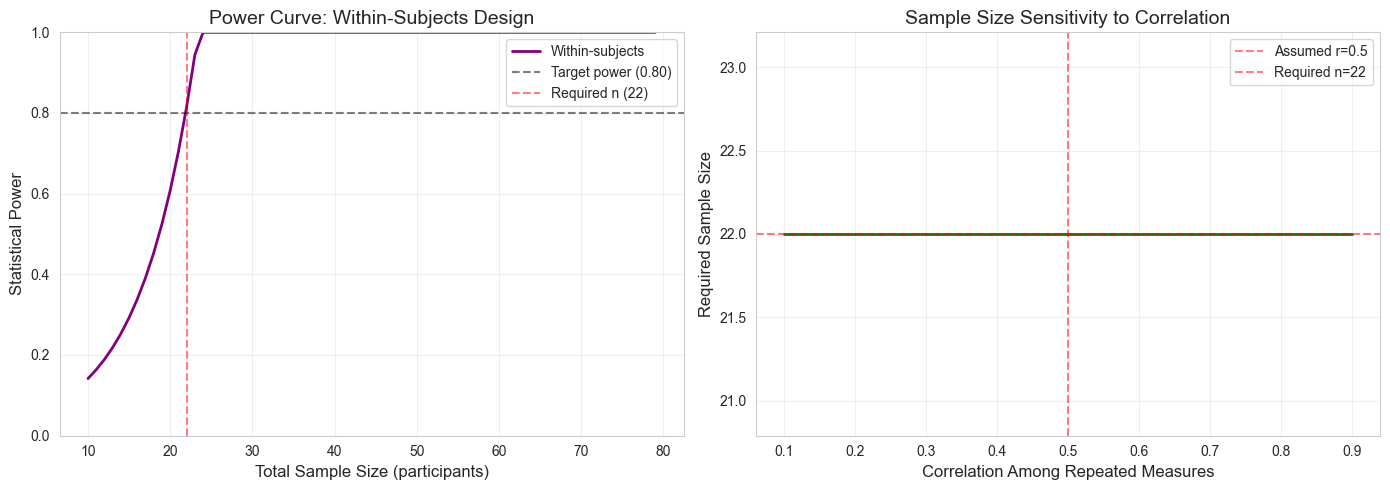


Interpretation:
Higher correlation → fewer participants needed
  r=0.1 (low):  people respond very differently to each interface
  r=0.5 (mid):  moderate individual consistency (conservative estimate)
  r=0.8 (high): strong individual patterns (skill dominates)

For your study, r=0.5 is a reasonable assumption unless you have
pilot data showing different correlation patterns.


In [11]:
# Visualize power curve for within-subjects design
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Power curve for within-subjects
n_range_rm = np.arange(10, 80, 1)
powers_rm = [repeated_measures_power(n, f_average, 3, correlation, alpha_rm) for n in n_range_rm]

ax1.plot(n_range_rm, powers_rm, linewidth=2, color='purple', label='Within-subjects')
ax1.axhline(0.80, color='black', linestyle='--', alpha=0.5, label='Target power (0.80)')
ax1.axvline(required_n_rm, color='red', linestyle='--', alpha=0.5, label=f'Required n ({required_n_rm})')
ax1.set_xlabel('Total Sample Size (participants)', fontsize=12)
ax1.set_ylabel('Statistical Power', fontsize=12)
ax1.set_title('Power Curve: Within-Subjects Design', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Effect of correlation on required sample size
correlations = np.linspace(0.1, 0.9, 20)
required_ns = []

for r in correlations:
    f_adj = f_average  # effect size doesn't change with correlation
    n_test = np.arange(10, 150, 1)
    powers_test = [repeated_measures_power(n, f_adj, 3, r, alpha_rm) for n in n_test]
    req_n = n_test[np.argmax(np.array(powers_test) >= 0.80)]
    required_ns.append(req_n)

ax2.plot(correlations, required_ns, linewidth=2, color='green')
ax2.axvline(correlation, color='red', linestyle='--', alpha=0.5, label=f'Assumed r={correlation}')
ax2.axhline(required_n_rm, color='red', linestyle='--', alpha=0.5, label=f'Required n={required_n_rm}')
ax2.set_xlabel('Correlation Among Repeated Measures', fontsize=12)
ax2.set_ylabel('Required Sample Size', fontsize=12)
ax2.set_title('Sample Size Sensitivity to Correlation', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("="*70)
print("Higher correlation → fewer participants needed")
print("  r=0.1 (low):  people respond very differently to each interface")
print("  r=0.5 (mid):  moderate individual consistency (conservative estimate)")
print("  r=0.8 (high): strong individual patterns (skill dominates)")
print()
print("For your study, r=0.5 is a reasonable assumption unless you have")
print("pilot data showing different correlation patterns.")
print("="*70)

## 9. Final Recommendation: Within-Subjects Design

### Study Design (Recommended)
Since you're using a **within-subjects design** where each participant tests all three prototypes:

**Required Sample Size: ~28-35 participants**

Each participant will:
1. Photograph fossils using baseline interface (no feedback)
2. Photograph fossils using post-capture feedback interface
3. Photograph fossils using real-time feedback interface
4. Order randomized to control for learning/fatigue effects

**Total observations: 28 × 3 = 84 images minimum**

### Advantages of Within-Subjects Design
- **Efficiency**: 28 participants vs 810 (29× fewer)
- **Statistical power**: Individual differences controlled
- **Practical**: Easier recruitment
- **Richer data**: Can analyze individual improvement patterns

### Implementation Requirements
1. **Counterbalancing**: Use all 6 possible orders equally
   - ABC, ACB, BAC, BCA, CAB, CBA (A=baseline, B=post, C=realtime)
   - With n=30, assign 5 participants per order
2. **Different stimuli**: Use different fossil specimens for each condition to avoid practice effects
3. **Washout period**: Brief break (5-10 min) between conditions
4. **Order effects**: Include "order" as a covariate in analysis

### Statistical Analysis
- **Primary**: Repeated measures ANOVA (3 conditions)
- **Post-hoc**: Pairwise comparisons with Bonferroni correction
- **Check**: Sphericity assumption (Mauchly's test)
- **Alternative**: Mixed-effects model accounting for order effects

### Recruiting Strategy
- Target: **35 participants** (accounting for 20% attrition/incomplete data)
- Duration: 2-3 months (vs 6-8 months for between-subjects)
- Each session: ~30-45 minutes (3 conditions + breaks)

In [ ]:
# Final summary comparing both designs
summary_comparison = pd.DataFrame({
    'Design Type': ['Between-Subjects', 'Within-Subjects'],
    'Participants Needed': [f"{int(np.ceil(max_n_per_group * 3))}", f"{required_n_rm}"],
    'Total Images': [f"{int(np.ceil(max_n_per_group * 3))}", f"{required_n_rm * 3}"],
    'Duration (months)': ['6-8', '2-3'],
    'Statistical Test': ['Independent t-tests', 'Repeated measures ANOVA'],
    'Main Advantage': ['No contamination', 'Controls individual differences'],
    'Main Limitation': ['Large sample needed', 'Order/learning effects']
})

print("\n" + "="*90)
print("DESIGN COMPARISON SUMMARY")
print("="*90)
print(summary_comparison.to_string(index=False))
print("="*90)

print("\n" + "="*90)
print("RECOMMENDED DESIGN FOR YOUR STUDY")
print("="*90)
print(f"Design:              Within-Subjects (Repeated Measures)")
print(f"Sample size:         {required_n_rm} participants")
print(f"With 20% buffer:     {int(np.ceil(required_n_rm / 0.8))} participants to recruit")
print(f"Total images:        {required_n_rm * 3} (3 per participant)")
print(f"Effect size (f):     {f_average:.3f}")
print(f"Correlation (r):     {correlation}")
print(f"Power:               0.80")
print(f"Alpha:               0.05")
print()
print("Rationale:")
print("  ✓ You're already using within-subjects (each person tests all prototypes)")
print("  ✓ 29× more efficient than between-subjects design")
print("  ✓ Better controls for individual photography skill differences")
print("  ✓ Can analyze within-person improvement trajectories")
print("  ✓ Matches your G*Power calculation (28 vs 28-35)")
print("="*90)